In [1]:
from __future__ import print_function, division
import sys
import pickle
import numpy as np
import scipy
import matplotlib
from matplotlib import pyplot as plt
from six.moves import range
import time
from scipy.special import logsumexp
from scipy.stats import truncnorm
import h5py

import brutus

# plot in-line within the notebook
%matplotlib inline

In [2]:
# re-defining plotting defaults
from matplotlib import rcParams
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'xtick.color': 'k'})
rcParams.update({'ytick.color': 'k'})
rcParams.update({'font.size': 30})

In [3]:
# import MIST models
from brutus import seds
filters = seds.gaia + seds.ps + seds.tmass
version = 'v4.1'
f = h5py.File('data/grid_'+version+'.h5')
params = f['parameters'][:]
labels = f['labels'][:]
mag_coeffs = f['mag_coeffs']
models = np.zeros((len(labels), len(filters), len(mag_coeffs[0][0])), dtype='float32')
for i, filt in enumerate(filters):
    sys.stderr.write('\rReading filter {}              '.format(filt))
    sys.stderr.flush()
    models[:, i] = mag_coeffs[filt]  # fitted magnitude coefficients
Nmodels, Nbands, Ncoef = models.shape

Reading filter 2MASS_Ks                    

In [4]:
# combine labels
lnames = ['mini', 'feh', 'loga', 'logl', 'logt', 'logg']
combined_params = np.zeros(Nmodels, dtype=np.dtype([(n, np.float) for n in lnames]))
for n in labels.dtype.names:
    if n in lnames:
        combined_params[n] = labels[n]
for n in params.dtype.names:
    if n in lnames:
        combined_params[n] = params[n]

In [5]:
# import Bayestar models
filters = seds.ps + seds.tmass
version_bayestar = 'v1'
f = h5py.File('data/grid_bayestar_'+version_bayestar+'.h5')
labels_bayestar = f['labels'][:]
mag_coeffs = f['mag_coeffs']
models_bayestar = np.zeros((len(labels_bayestar), len(filters), 
                            len(mag_coeffs[0][0])), dtype='float32')
for i, filt in enumerate(filters):
    sys.stderr.write('\rReading filter {}              '.format(filt))
    sys.stderr.flush()
    models_bayestar[:, i] = mag_coeffs[filt]  # fitted magnitude coefficients
Nmodels_bayestar, Nbands_bayestar, Ncoef_bayestar = models_bayestar.shape

Reading filter 2MASS_Ks              

In [6]:
# load in data
from frankenz.pdf import inv_magnitude
f = h5py.File('data/GaiaHackWeek.00000.h5')
fpix = f['photometry']['pixel 128-32188']
mag, magerr = fpix['mag'], fpix['err']
phot, err = inv_magnitude(mag, magerr)
mask = ~np.isclose(mag, 0.)
objid = fpix['obj_id']
parallax, parallax_err = fpix['parallax'], fpix['parallax_error']
psel = np.isnan(parallax) | np.isnan(parallax_err) | np.isclose(parallax_err, 0.)
parallax[psel], parallax_err[psel] = np.nan, np.nan
coords = np.c_[fpix['l'], fpix['b']]

Nobjs = len(phot)

In [7]:
# parallel computing
import ipyparallel as ipp

# check cores
# note that these include virtual cores
rc = ipp.Client()
nprocs = len(rc.ids)
print(rc.ids)

# switch to dill for robustness
dview = rc[:]
dview.use_dill();

# define pool
class Pool(object):
    """A simple wrapper for `dview`."""
    
    def __init__(self, dview):
        self.dview = dview
        self.size = nprocs
        
    def map(self, function, tasks):
        return self.dview.map_sync(function, tasks)

[0, 1, 2, 3, 4, 5, 6, 7]


In [8]:
%%px

# import environment
from __future__ import print_function, division
import sys, os
import numpy as np
import scipy
from six.moves import range
import h5py
import brutus


# seed the random number generator
np.random.seed(os.getpid())
print('Random seed:', os.getpid())

[stdout:0] Random seed: 3380
[stdout:1] Random seed: 3382
[stdout:2] Random seed: 3384
[stdout:3] Random seed: 3386
[stdout:4] Random seed: 3387
[stdout:5] Random seed: 3391
[stdout:6] Random seed: 3401
[stdout:7] Random seed: 3404


In [9]:
# initialize our pool
pool = Pool(dview)

In [10]:
# load in fitter
from brutus.fitting import BruteForce
BF = BruteForce(models[:, 3:], labels, models_params=params, pool=pool)
BF_bayestar = BruteForce(models_bayestar, labels_bayestar, pool=pool)

In [11]:
# MIST without gaia
t1 = time.time()
BF.fit(phot, err, mask, objid, 
       'data/GaiaHackWeek.00000_mist_nogaia_'+version,
       data_coords=coords)
t2 = time.time()
print('Avg time per object:', (t2 - t1) / Nobjs)

Fitting object 492/492


Avg time per object: 3.27835678667


In [12]:
# MIST with gaia
t1 = time.time()
BF.fit(phot, err, mask, objid, 
       'data/GaiaHackWeek.00000_mist_yesgaia_'+version, 
       parallax=parallax, parallax_err=parallax_err, 
       data_coords=coords)
t2 = time.time()
print('Avg time per object:', (t2 - t1) / Nobjs)

Fitting object 492/492


Avg time per object: 3.30792385776


In [13]:
# Bayestar without gaia
t1 = time.time()
BF_bayestar.fit(phot, err, mask, objid, 
                'data/GaiaHackWeek.00000_bayestar_nogaia_'+version_bayestar,
                data_coords=coords)
t2 = time.time()
print('Avg time per object:', (t2 - t1) / Nobjs)

brutus/fitting.py:555: UserWarning: No age weights provided in `models_params`. 
  warnings.warn("No age weights provided in `models_params`. ")
Fitting object 492/492


Avg time per object: 0.612231276384


In [14]:
# Bayestar with gaia
t1 = time.time()
BF_bayestar.fit(phot, err, mask, objid, 
                'data/GaiaHackWeek.00000_bayestar_yesgaia_'+version_bayestar,
                parallax=parallax, parallax_err=parallax_err,
                data_coords=coords)
t2 = time.time()
print('Avg time per object:', (t2 - t1) / Nobjs)

Fitting object 492/492


Avg time per object: 0.581996162732


In [15]:
# load in results

# MIST w/o gaia
f = h5py.File('data/GaiaHackWeek.00000_mist_nogaia_'+version+'.h5')
s_ng = f['scales'][:]
av_ng = f['avs'][:]
cov_ng = f['cov_sa'][:]
idxs_ng = f['idxs'][:]
chi2_ng = f['best_chi2'][:]
levid_ng = f['log_evidence'][:]

# MIST w/ gaia
f = h5py.File('data/GaiaHackWeek.00000_mist_yesgaia_'+version+'.h5')
s_yg = f['scales'][:]
av_yg = f['avs'][:]
cov_yg = f['cov_sa'][:]
idxs_yg = f['idxs'][:]
chi2_yg = f['best_chi2'][:]
levid_yg = f['log_evidence'][:]

# Bayestar w/o gaia
f = h5py.File('data/GaiaHackWeek.00000_bayestar_nogaia_'+version_bayestar+'.h5')
s_ng_bs = f['scales'][:]
av_ng_bs = f['avs'][:]
cov_ng_bs = f['cov_sa'][:]
idxs_ng_bs = f['idxs'][:]
chi2_ng_bs = f['best_chi2'][:]
levid_ng_bs = f['log_evidence'][:]

# Bayestar w/ gaia
f = h5py.File('data/GaiaHackWeek.00000_bayestar_yesgaia_'+version_bayestar+'.h5')
s_yg_bs = f['scales'][:]
av_yg_bs = f['avs'][:]
cov_yg_bs = f['cov_sa'][:]
idxs_yg_bs = f['idxs'][:]
chi2_yg_bs = f['best_chi2'][:]
levid_yg_bs = f['log_evidence'][:]

Best-fit chi2: 0.0751582


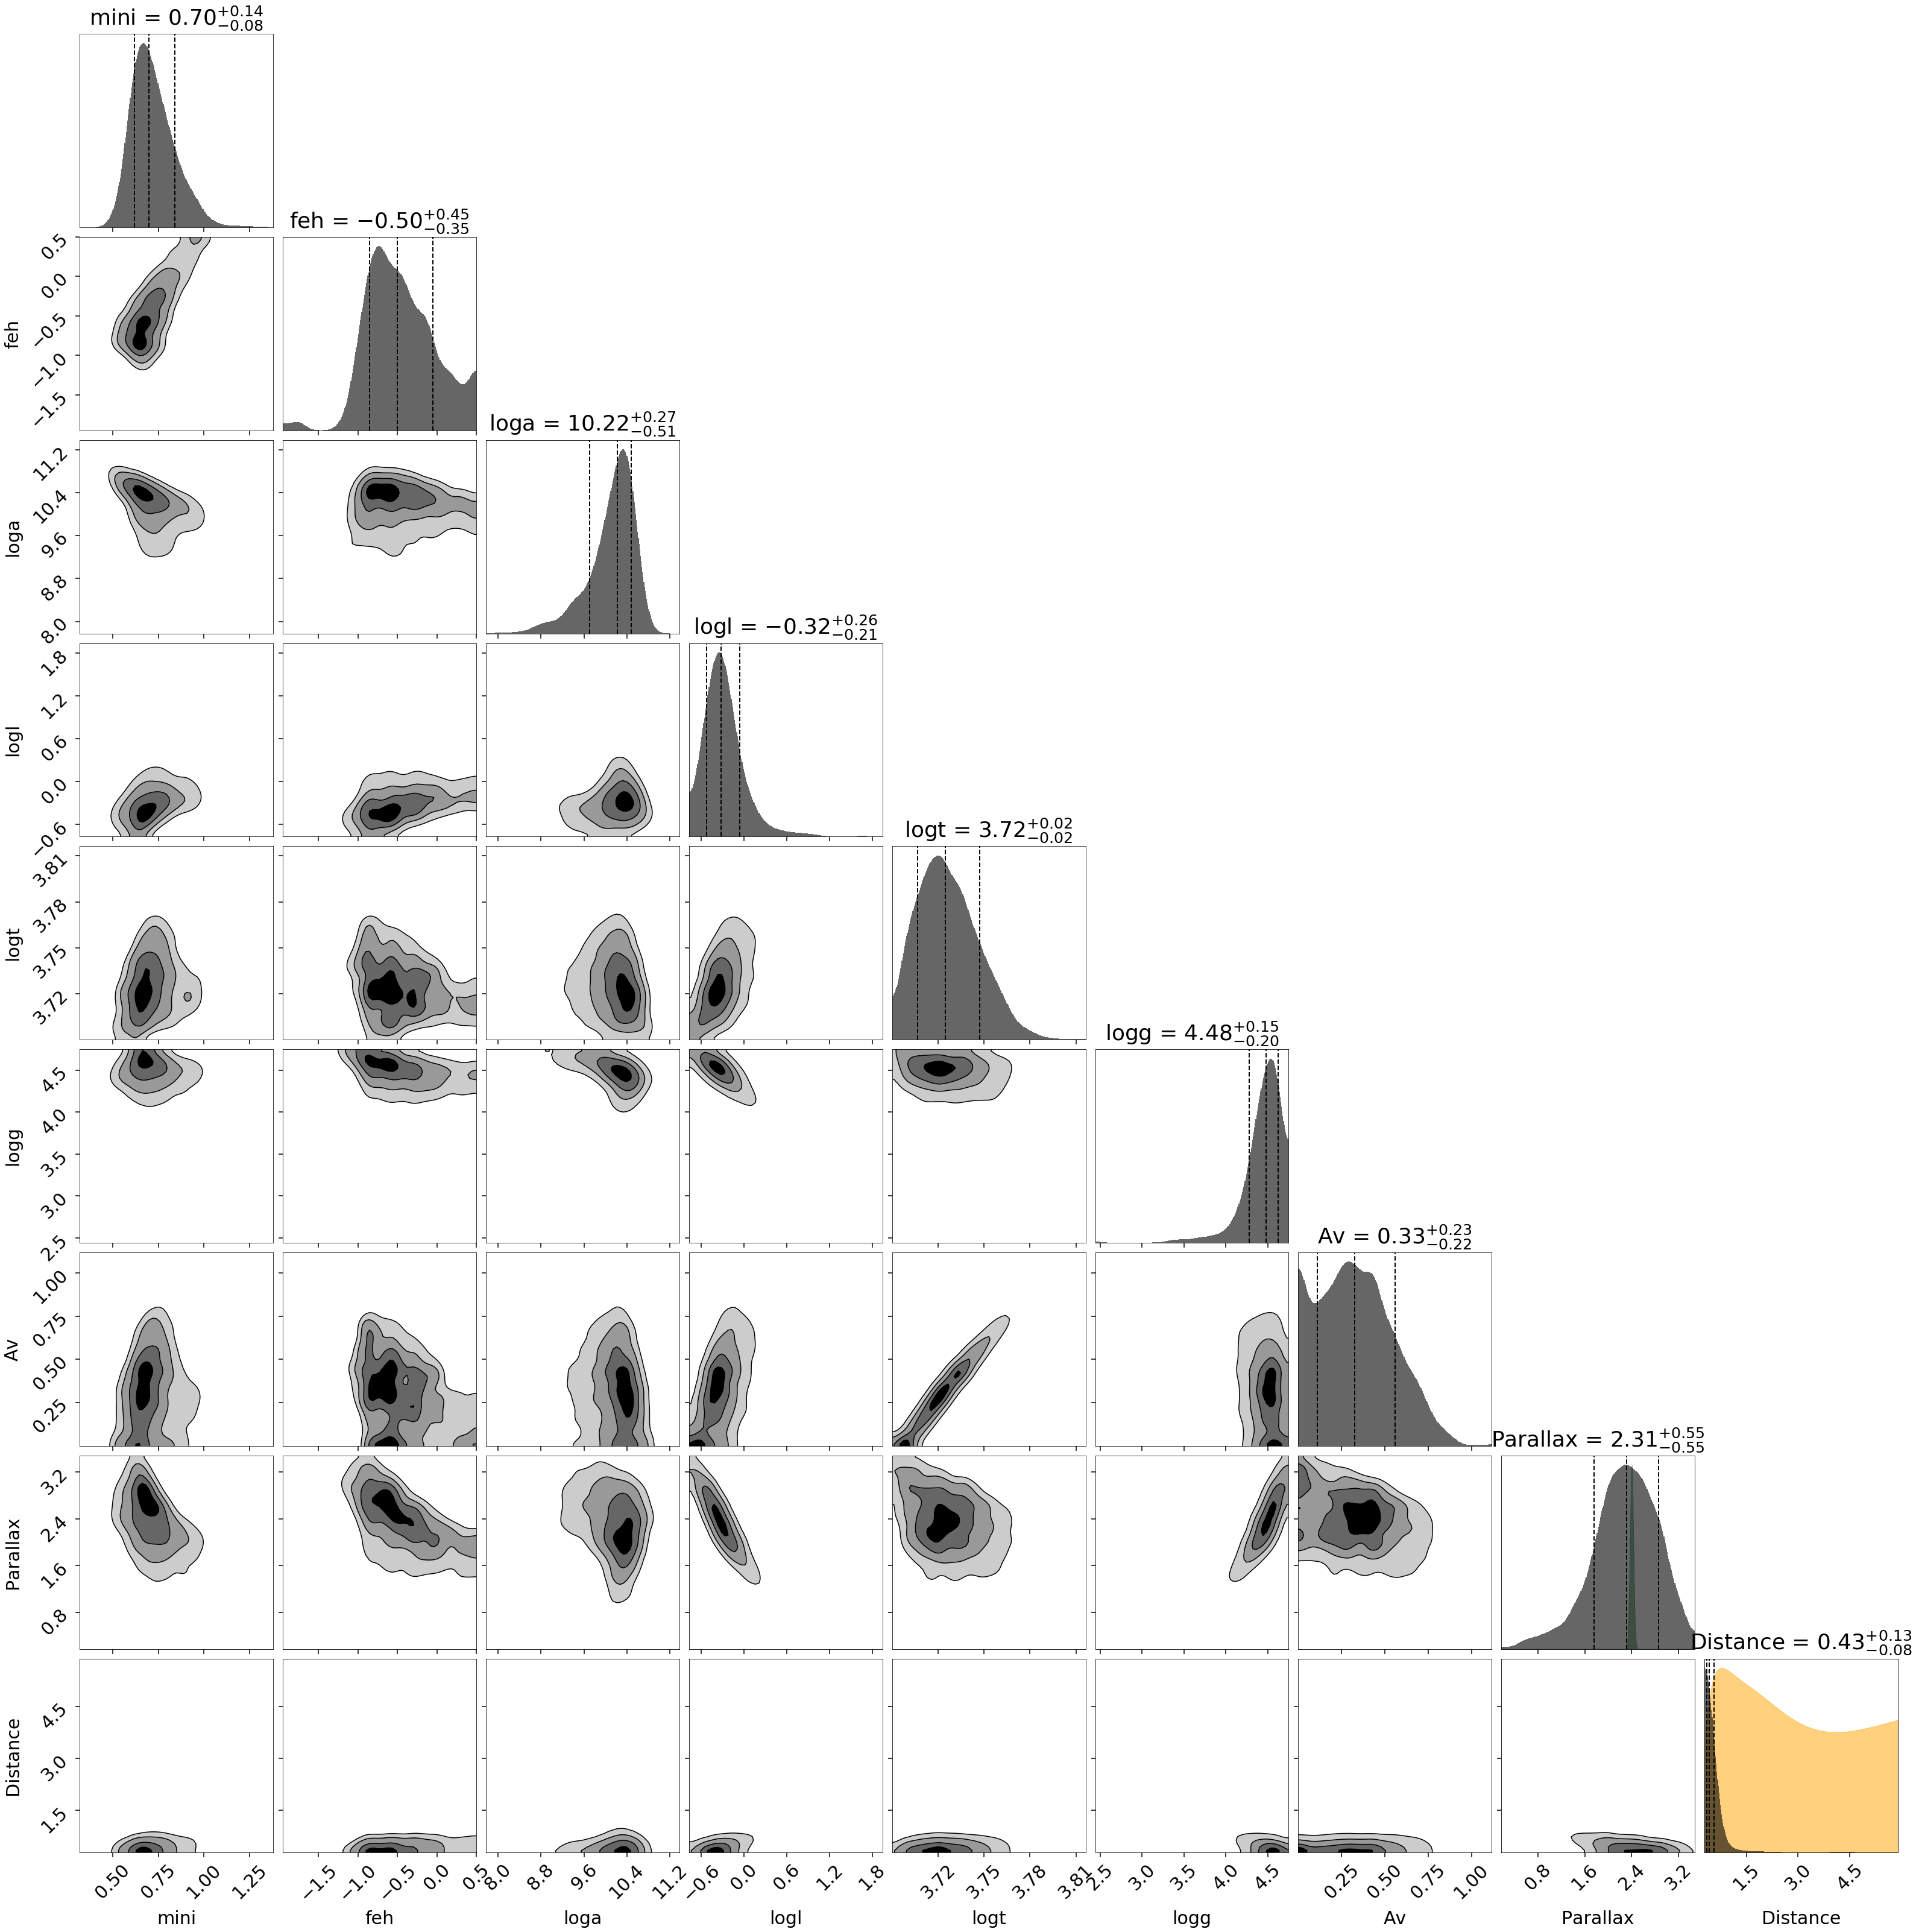

In [20]:
# plot snapshot of results
from brutus import plotting as bplot

i = 21

# MIST without gaia
print('Best-fit chi2:', chi2_ng[i])
fig, axes = bplot.cornerplot(idxs_ng[i], s_ng[i], av_ng[i], cov_ng[i],
                             combined_params, coord=coords[i],
                             parallax=parallax[i], parallax_err=parallax_err[i],
                             applied_parallax=False, pcolor='seagreen', dcolor='orange',
                             show_titles=True, title_kwargs={'y': 1.03},
                             fig=plt.subplots(9, 9, figsize=(45, 45)))

Best-fit chi2: 0.651182


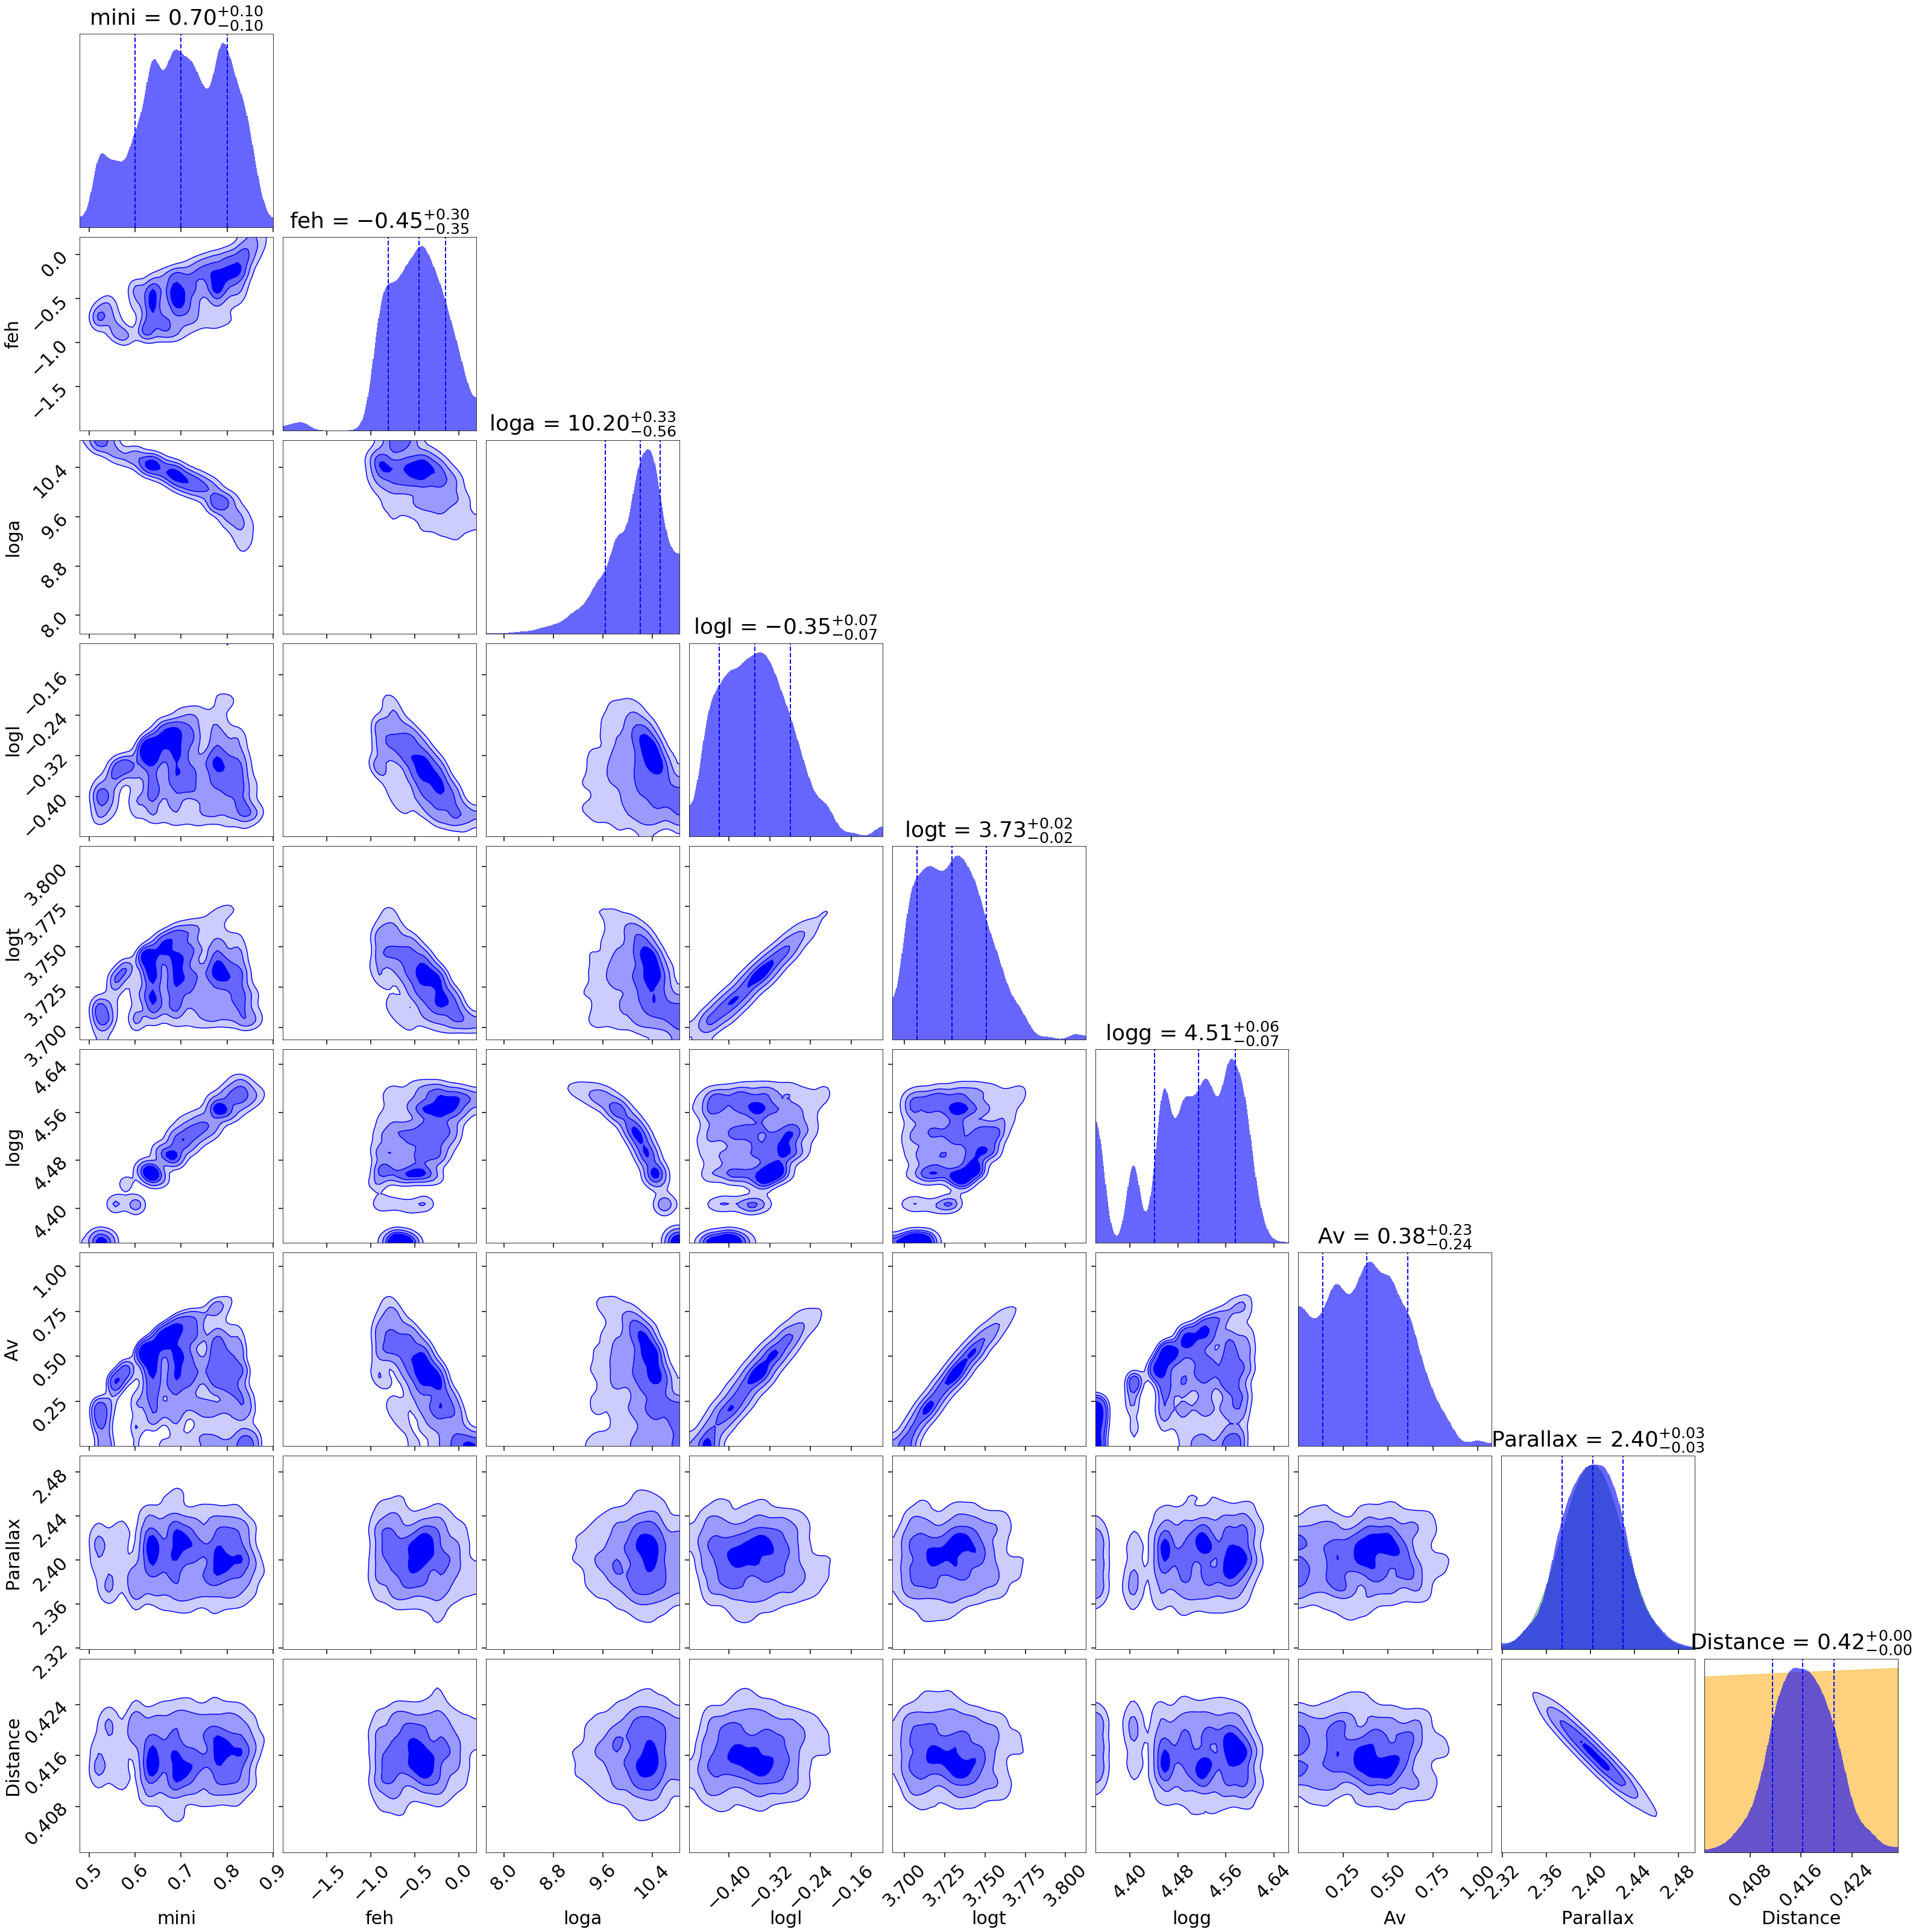

In [21]:
# MIST with gaia
print('Best-fit chi2:', chi2_yg[i])
fig, axes = bplot.cornerplot(idxs_yg[i], s_yg[i], av_yg[i], cov_yg[i],
                             combined_params, color='blue', coord=coords[i],
                             parallax=parallax[i], parallax_err=parallax_err[i],
                             applied_parallax=True, pcolor='seagreen', dcolor='orange',
                             show_titles=True, title_kwargs={'y': 1.03},
                             fig=plt.subplots(9, 9, figsize=(45, 45)))

Best-fit chi2: 0.759487


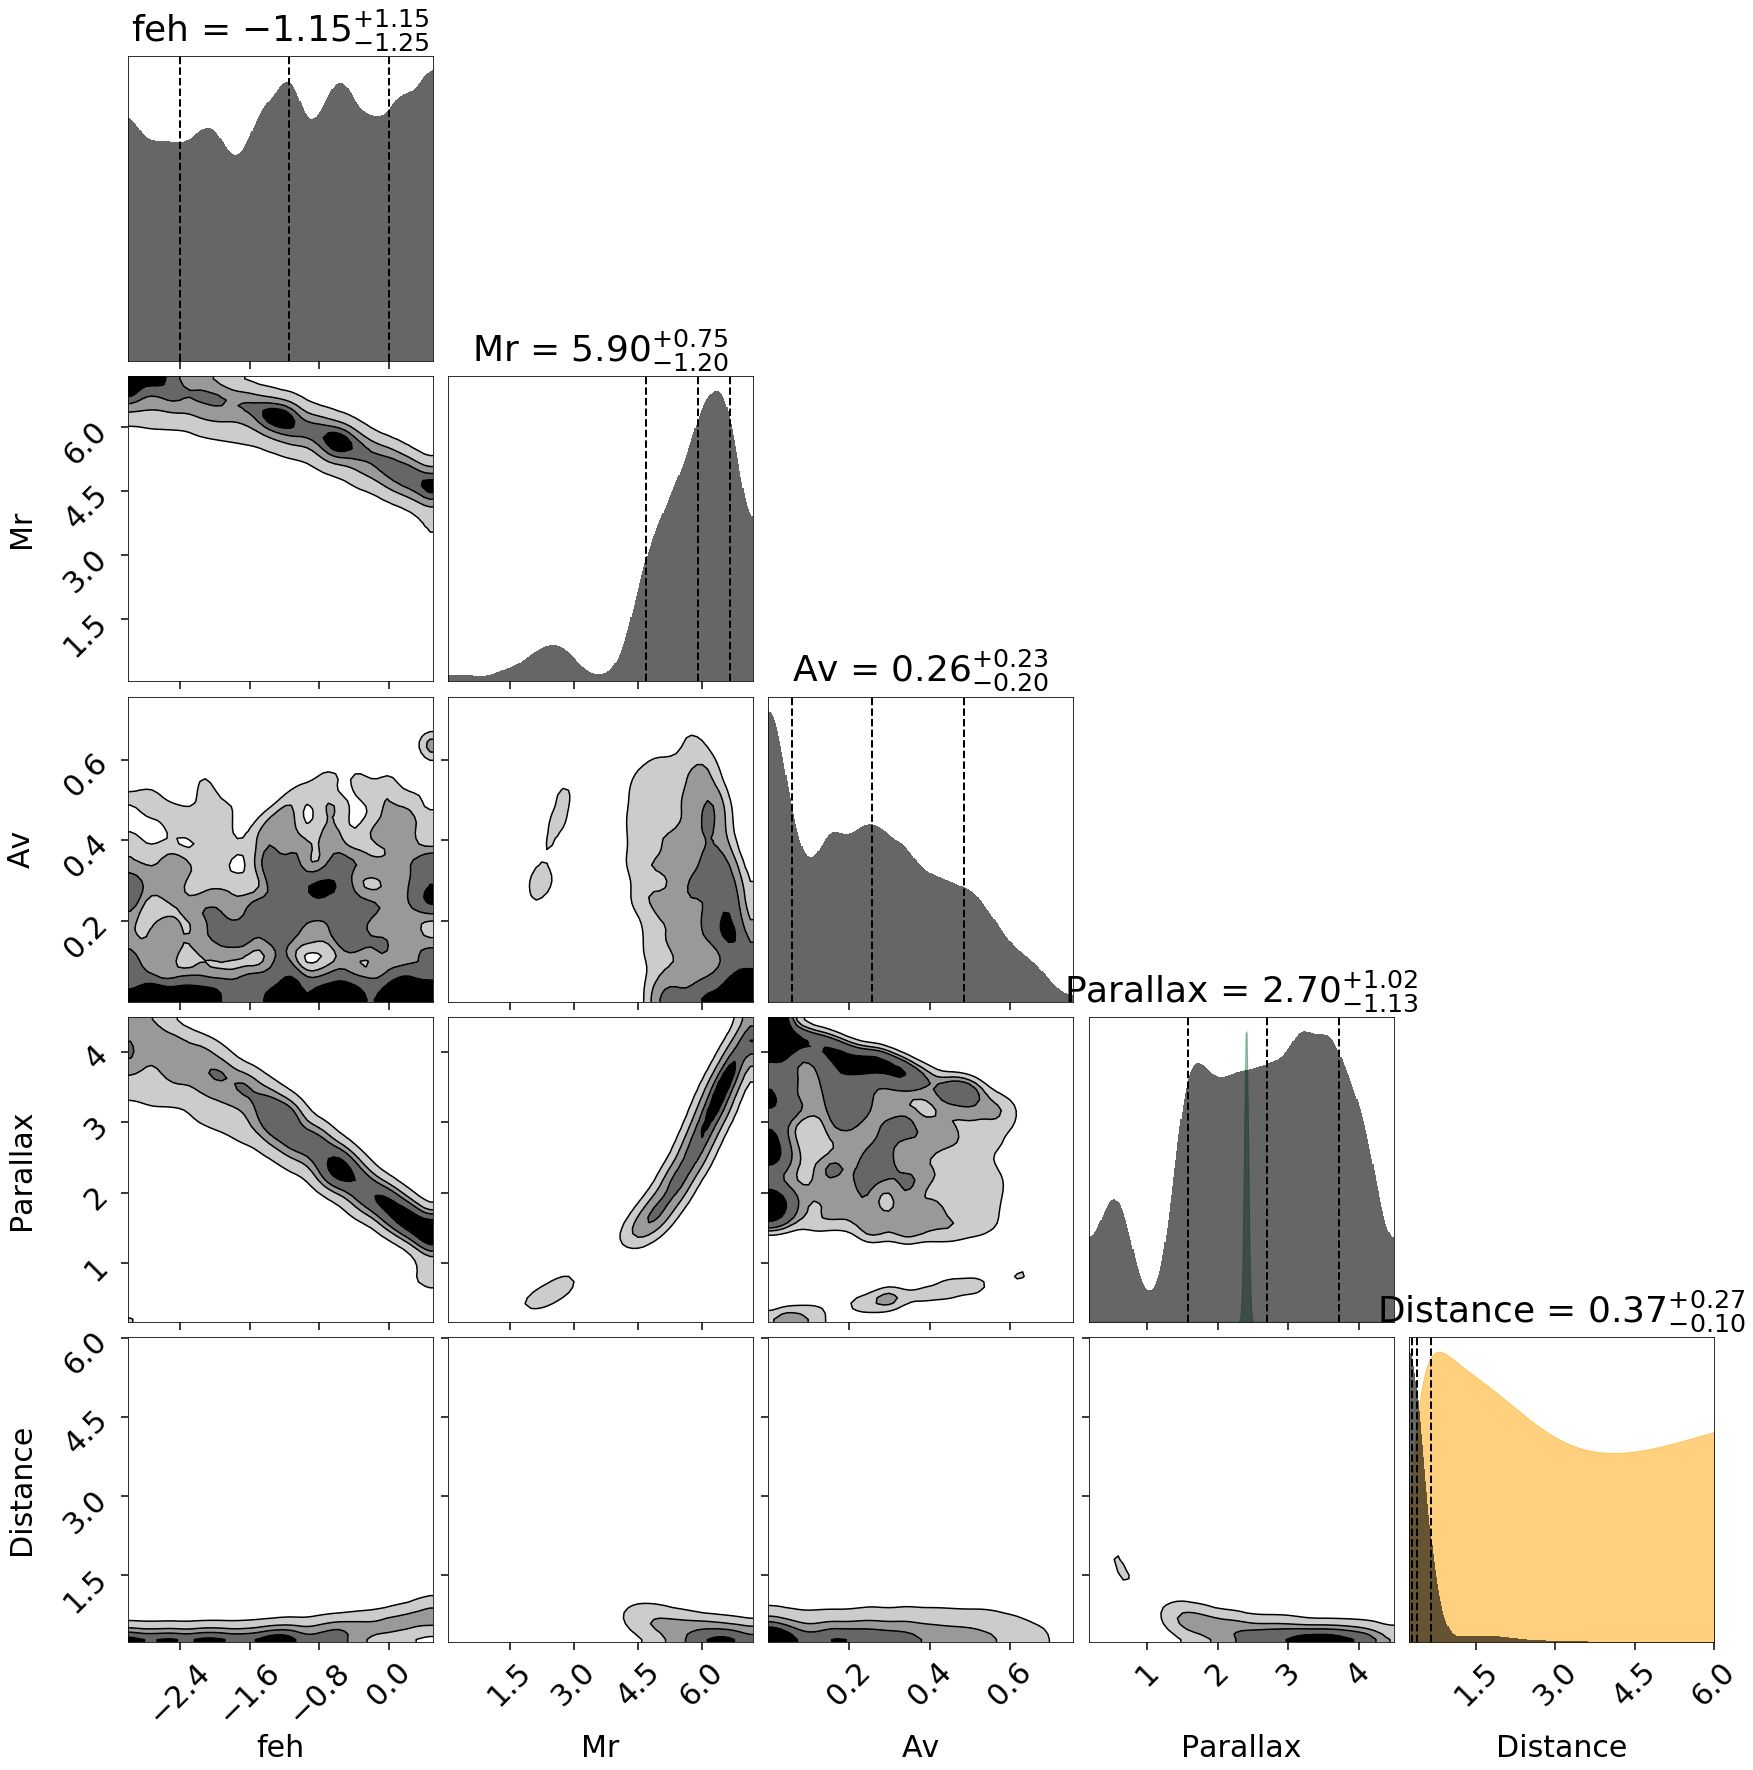

In [22]:
# Bayestar without gaia
print('Best-fit chi2:', chi2_ng_bs[i])
fig, axes = bplot.cornerplot(idxs_ng_bs[i], s_ng_bs[i], av_ng_bs[i], cov_ng_bs[i],
                             labels_bayestar, coord=coords[i],
                             parallax=parallax[i], parallax_err=parallax_err[i],
                             applied_parallax=False, pcolor='seagreen', dcolor='orange',
                             show_titles=True, title_kwargs={'y': 1.03},
                             fig=plt.subplots(5, 5, figsize=(25, 25)))

Best-fit chi2: 0.75995


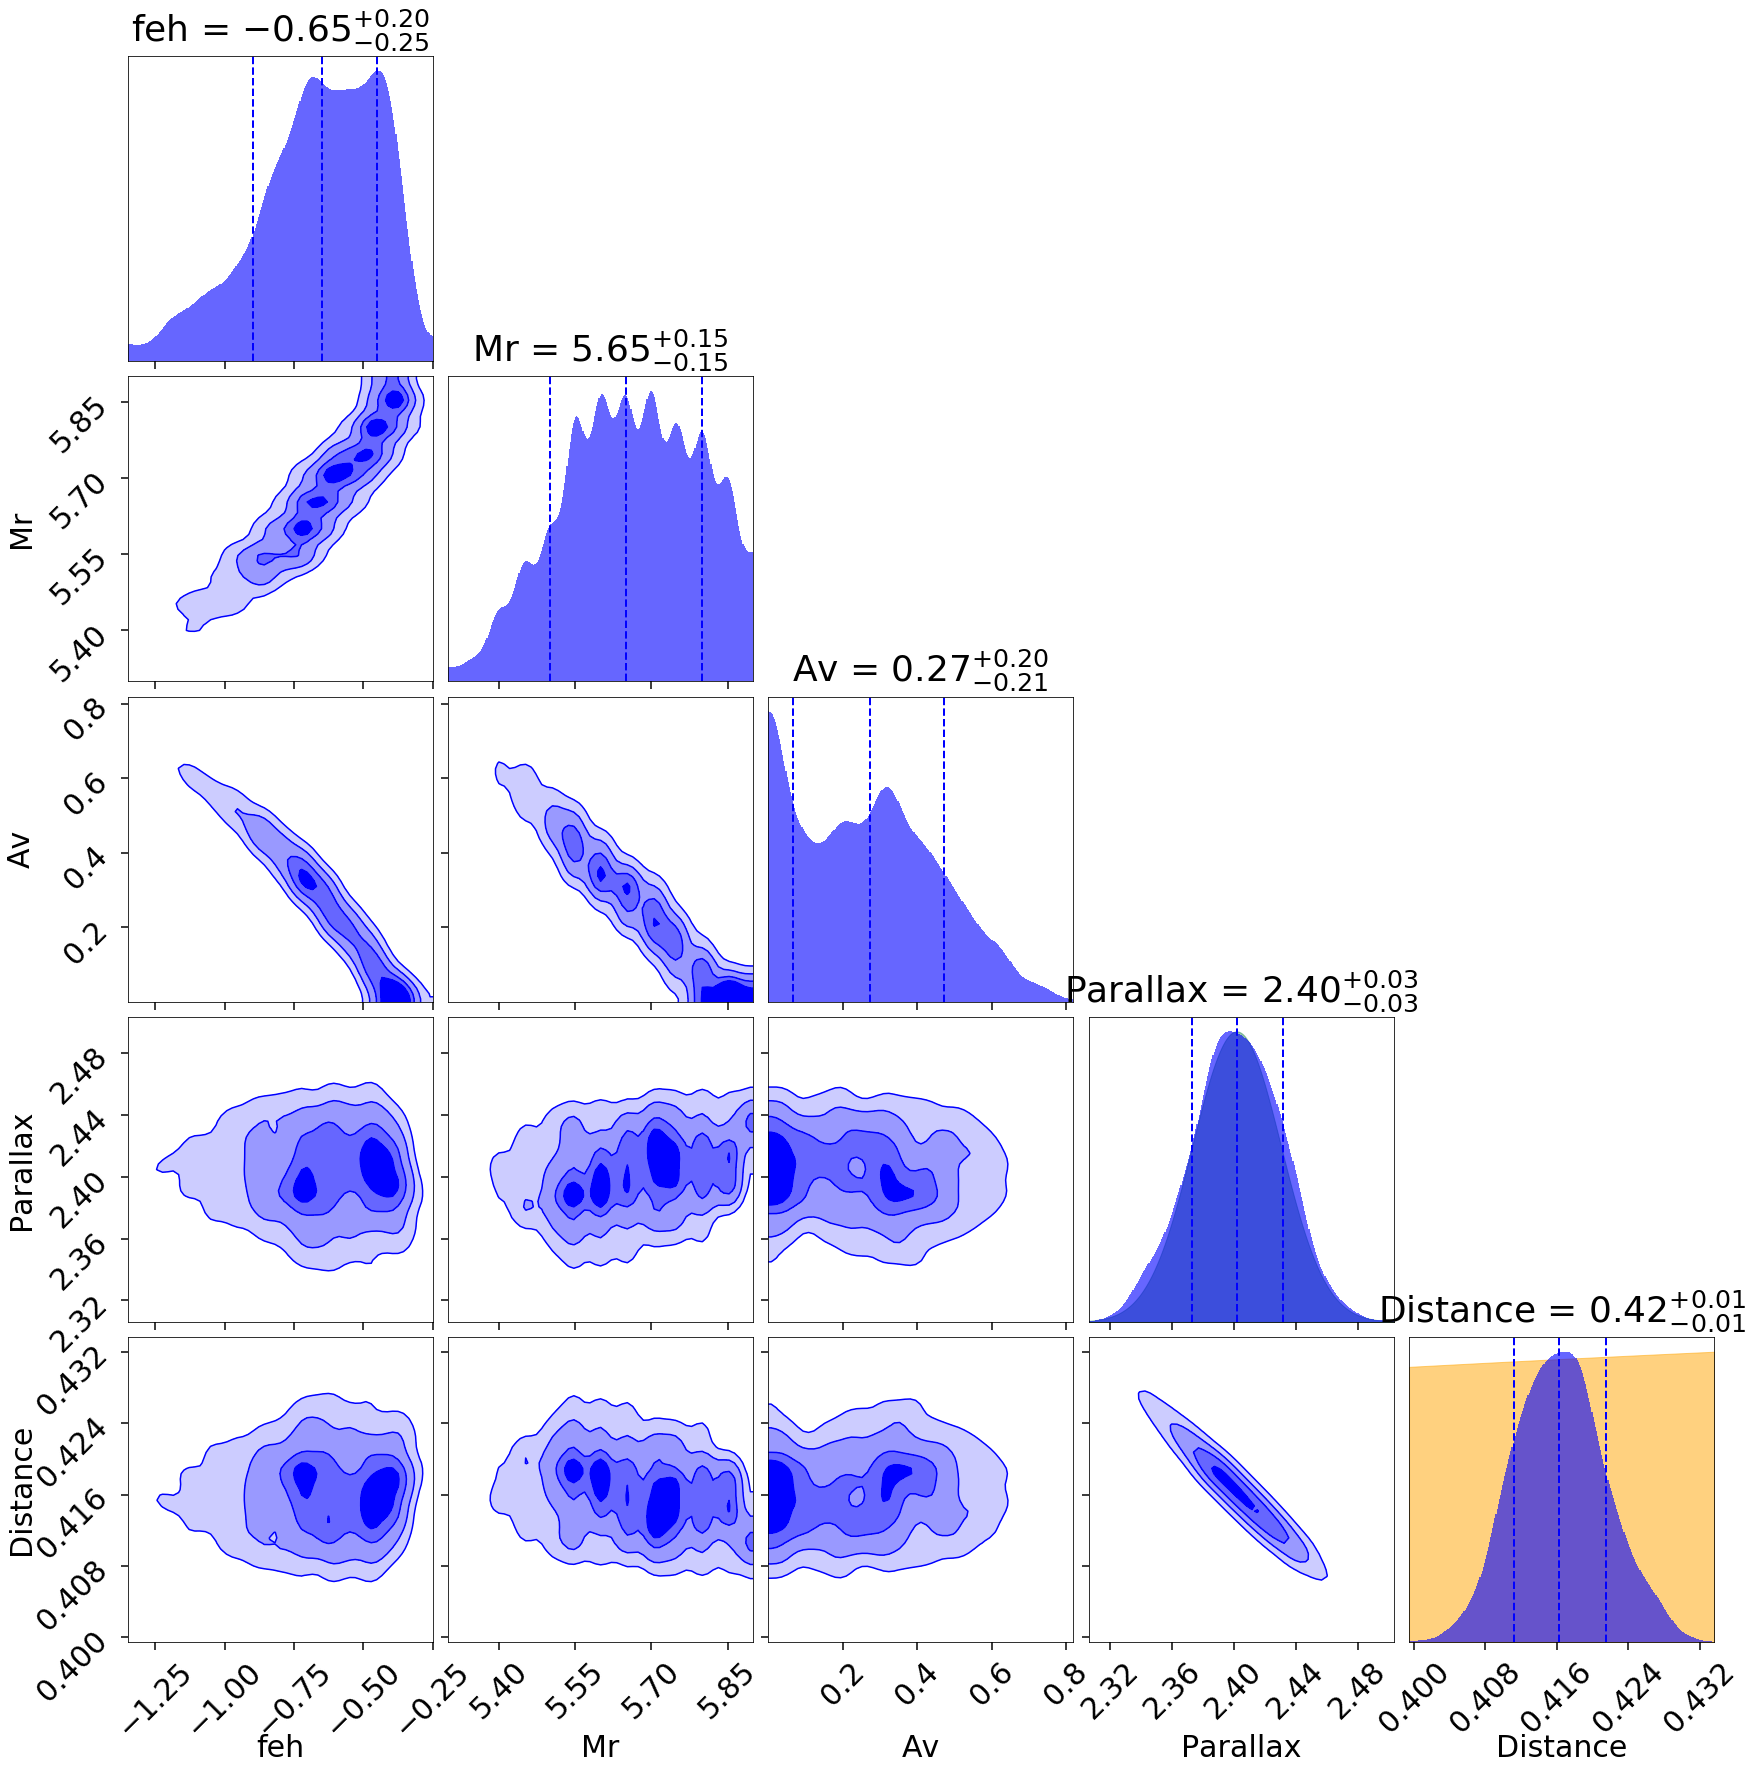

In [23]:
# Bayestar with gaia
print('Best-fit chi2:', chi2_yg_bs[i])
fig, axes = bplot.cornerplot(idxs_yg_bs[i], s_yg_bs[i], av_yg_bs[i], cov_yg_bs[i],
                             labels_bayestar, coord=coords[i], color='blue',
                             parallax=parallax[i], parallax_err=parallax_err[i],
                             applied_parallax=True, pcolor='seagreen', dcolor='orange',
                             show_titles=True, title_kwargs={'y': 1.03},
                             fig=plt.subplots(5, 5, figsize=(25, 25)))

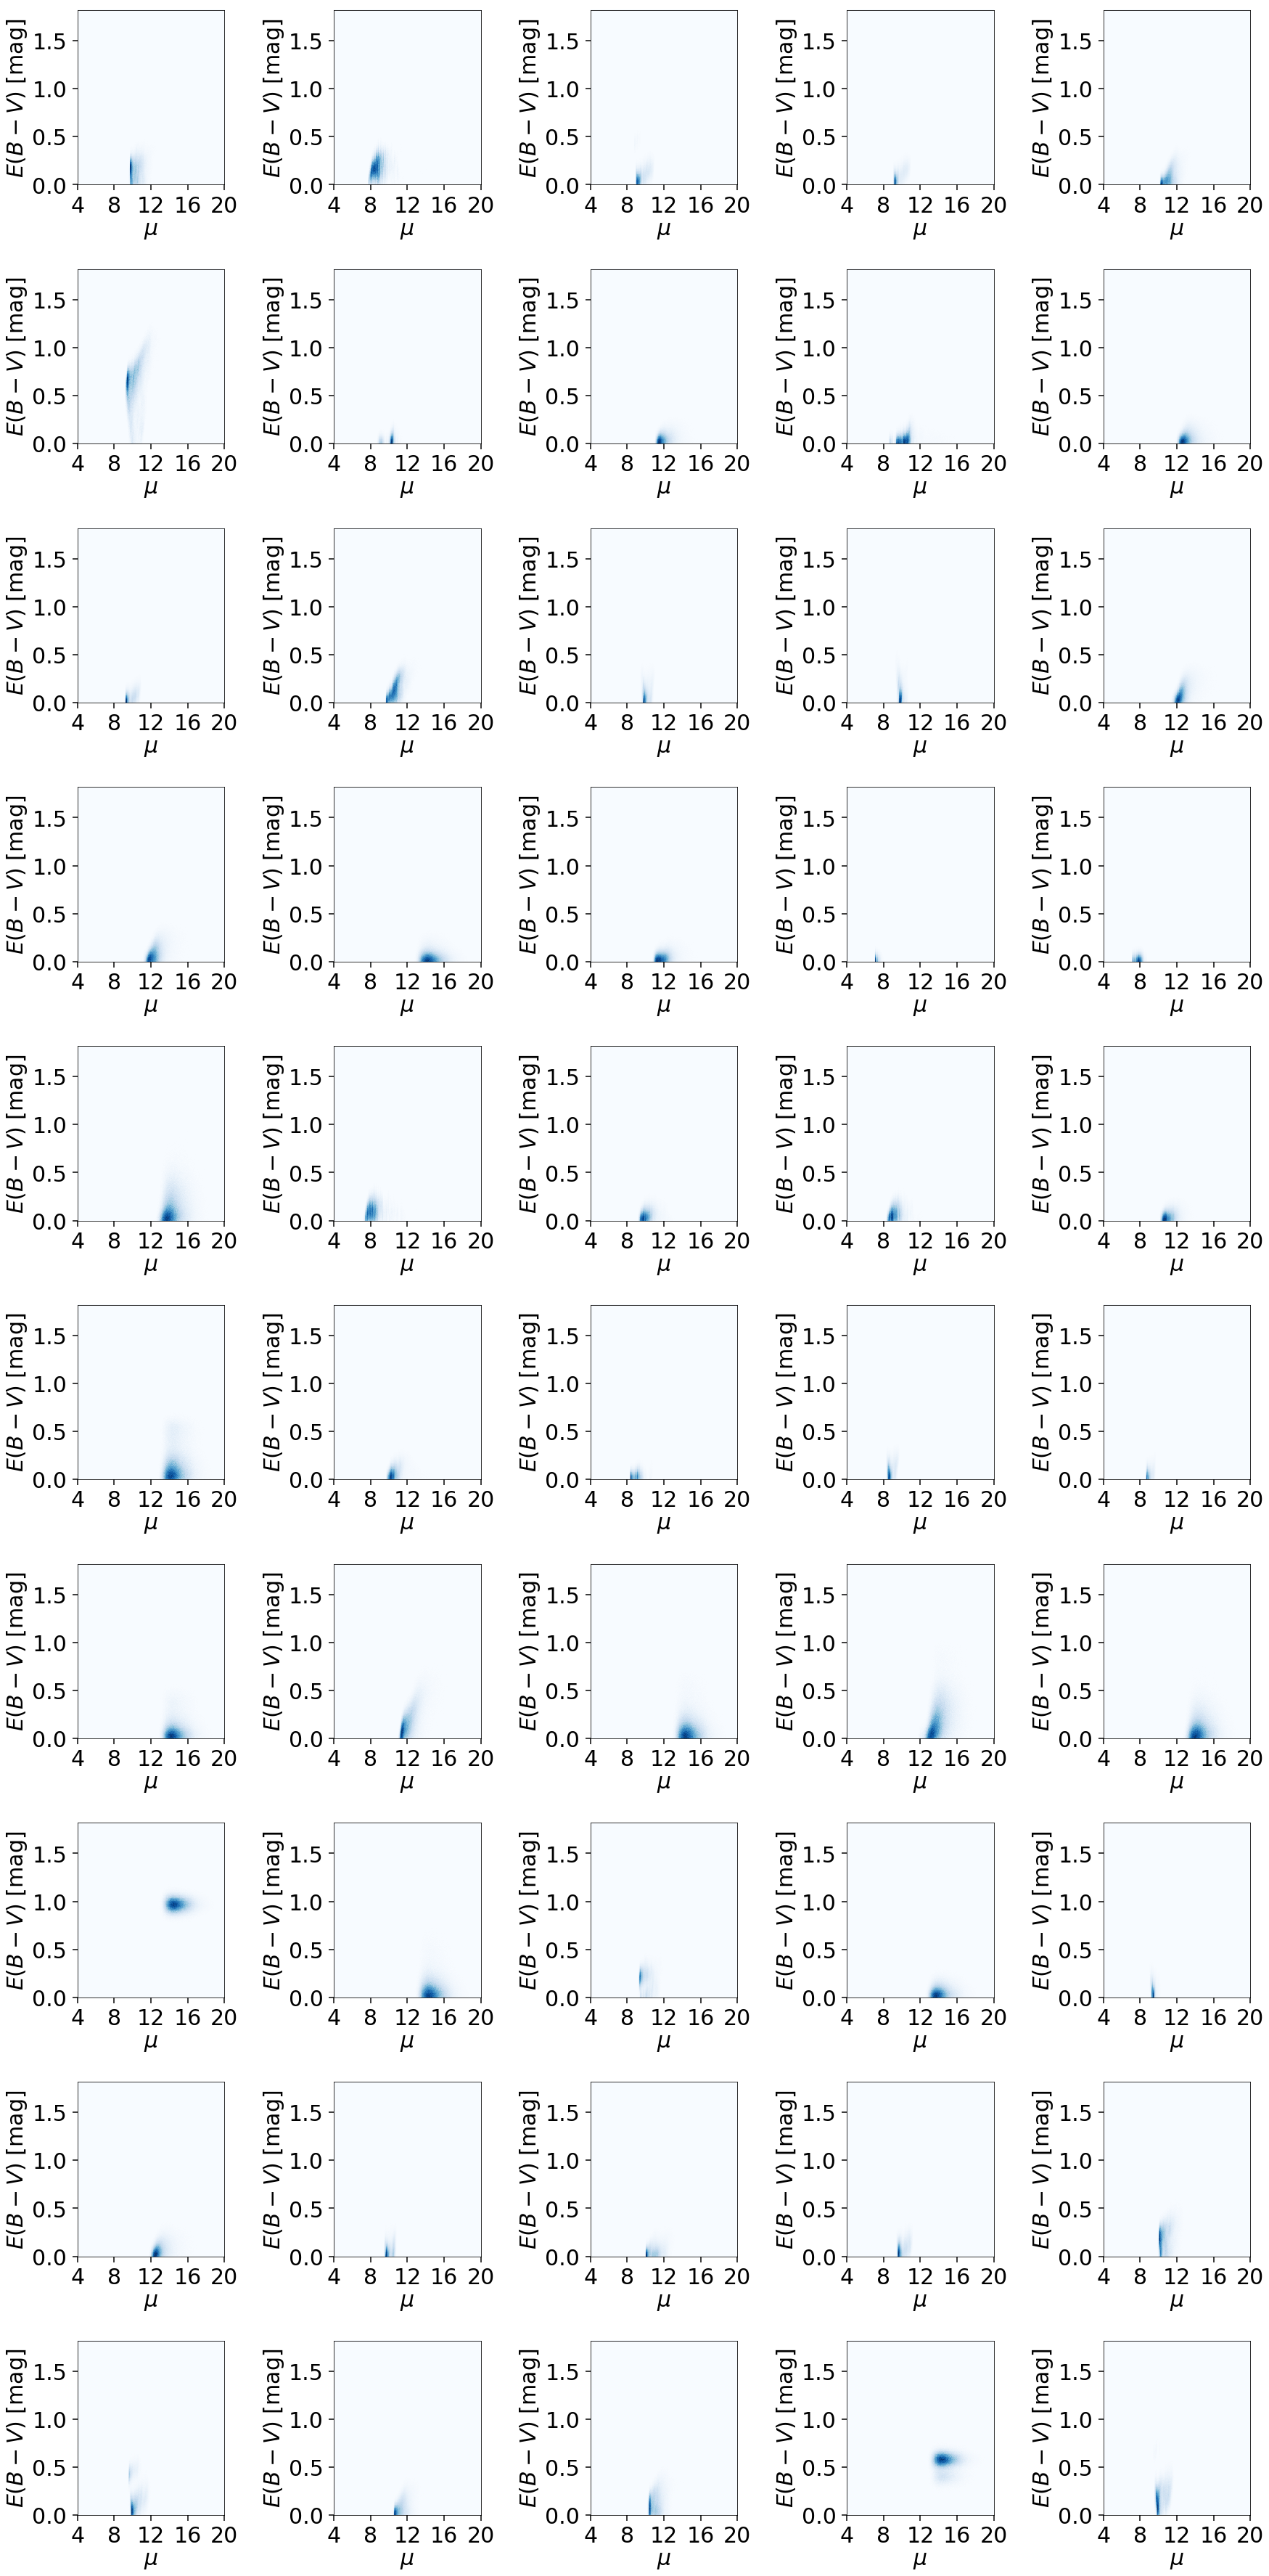

In [24]:
# MIST subset
xdim, ydim = 25, 50
plt.figure(figsize=(xdim, ydim))
for i in range(xdim//5 * ydim//5):
    plt.subplot(ydim//5, xdim//5, i+1)
    bplot.dist_vs_red(s_ng[i], av_ng[i], cov_ng[i], coord=coords[i])
    plt.xticks(np.arange(4., 21., 4.))
    plt.yticks(np.arange(0., 2., 0.5))
plt.tight_layout()

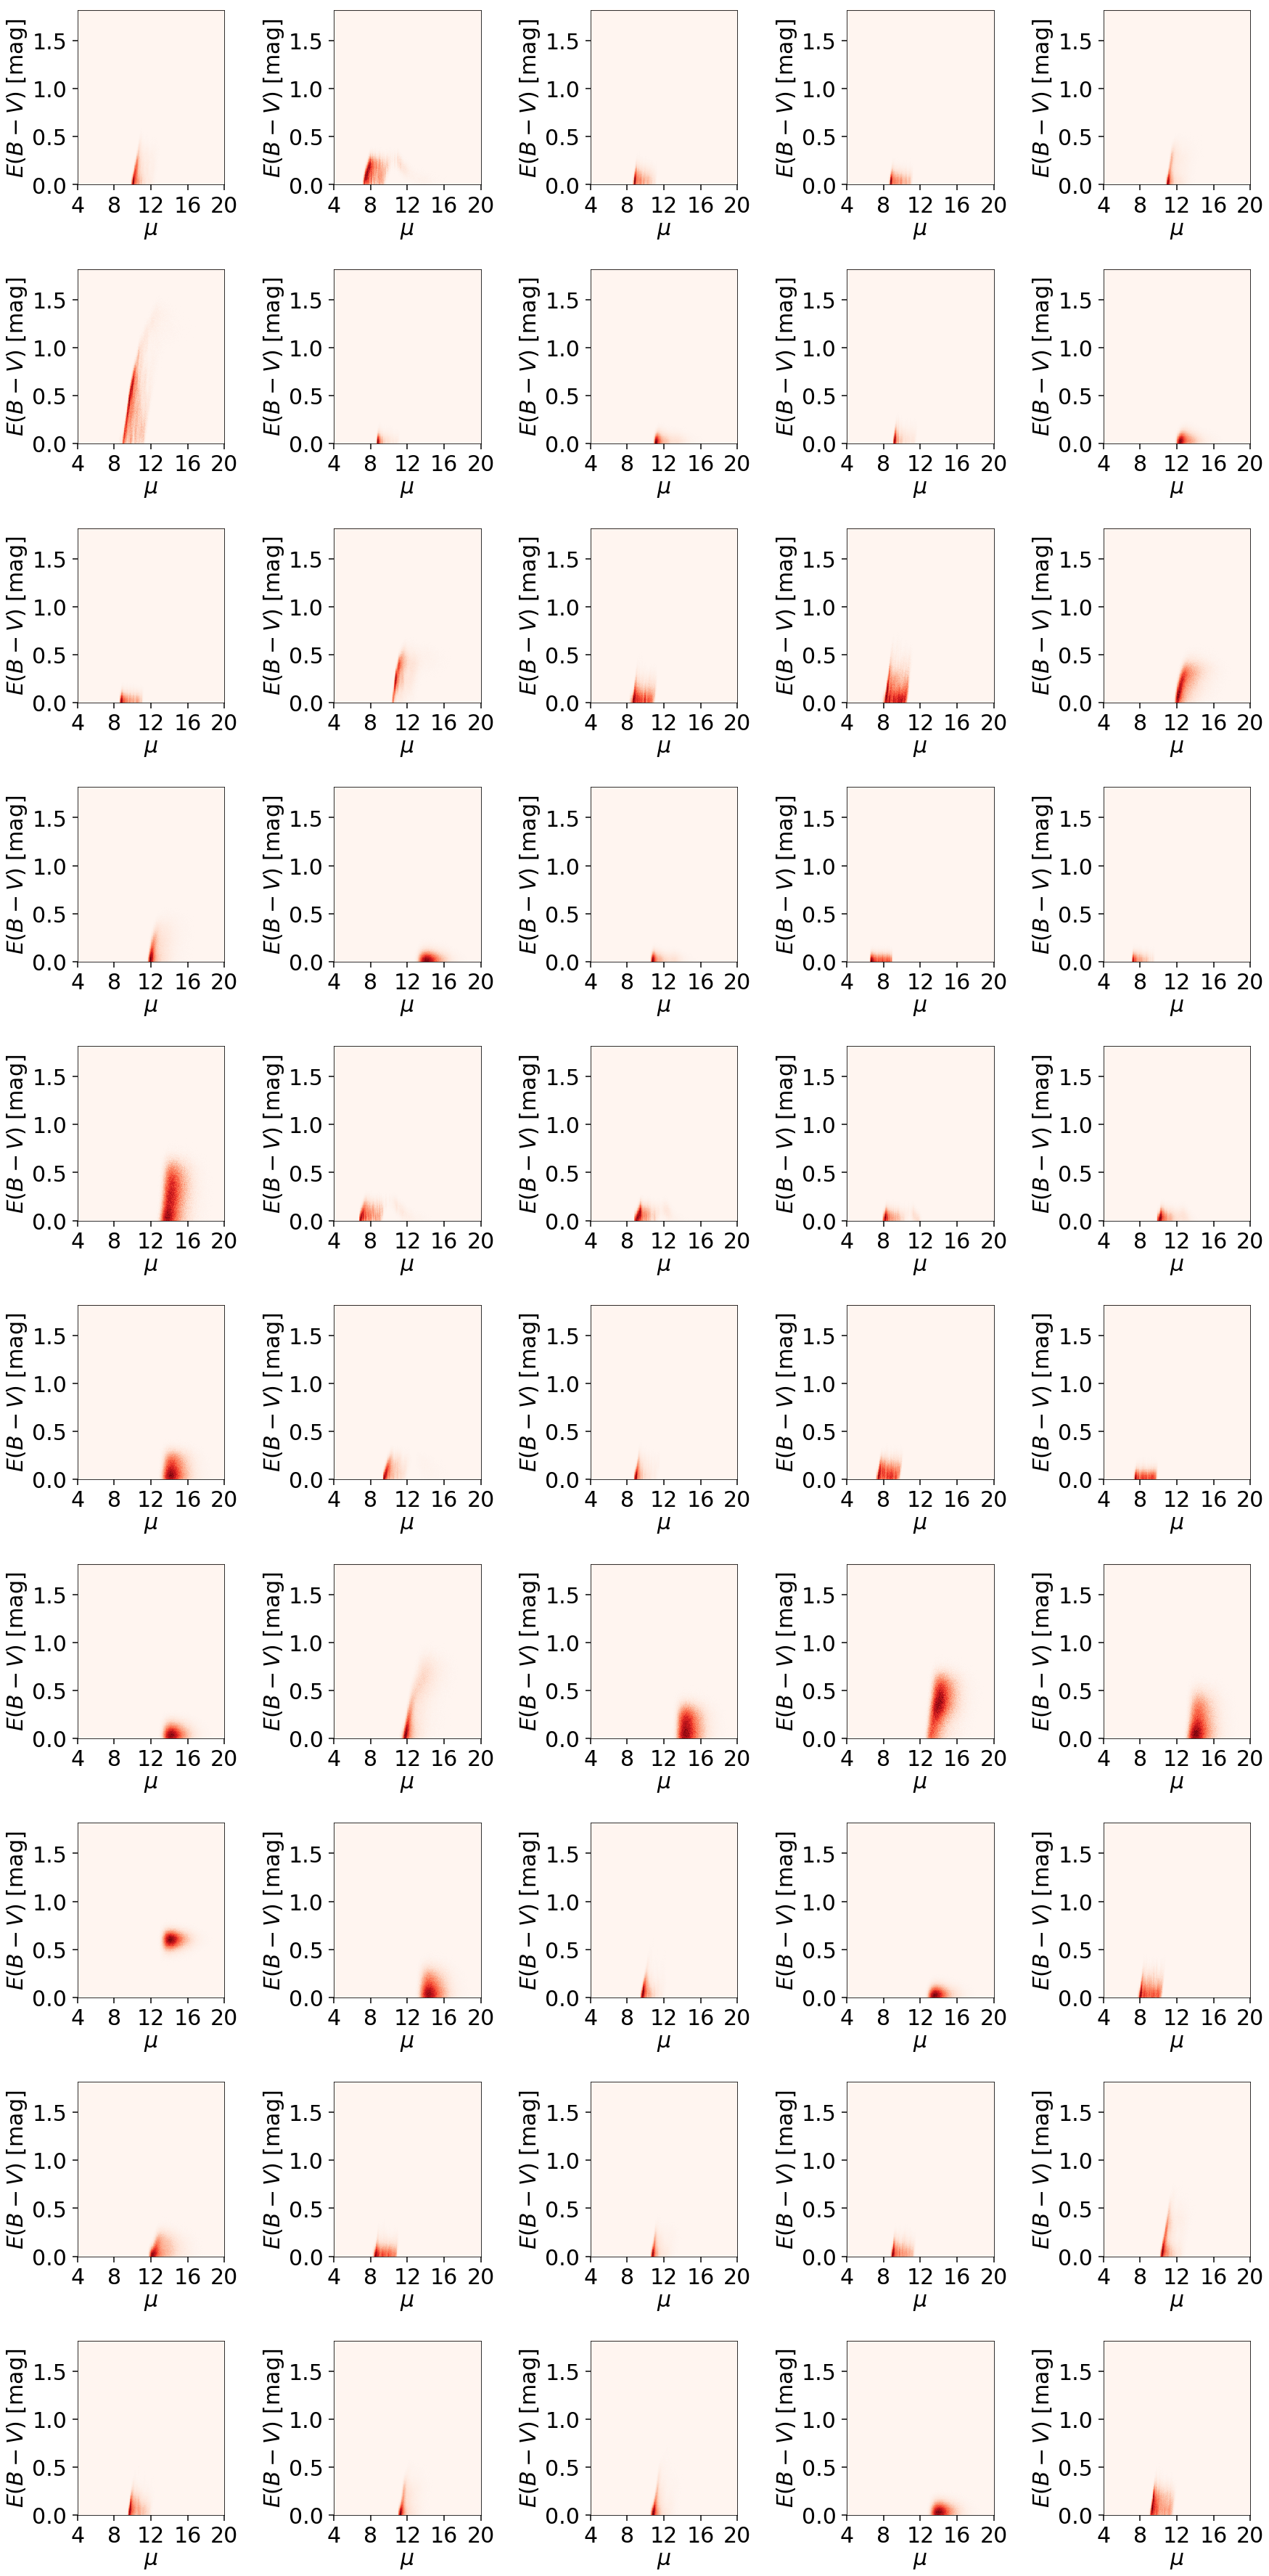

In [25]:
# Bayestar subset
xdim, ydim = 25, 50
plt.figure(figsize=(xdim, ydim))
for i in range(xdim//5 * ydim//5):
    plt.subplot(ydim//5, xdim//5, i+1)
    bplot.dist_vs_red(s_ng_bs[i], av_ng_bs[i], cov_ng_bs[i], coord=coords[i],
                      cmap='Reds')
    plt.xticks(np.arange(4., 21., 4.))
    plt.yticks(np.arange(0., 2., 0.5))
plt.tight_layout()